## import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
import matplotlib.cm as cm
import warnings
import math
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
from collections import Counter

from mybspline import MyBSpline


## blog

In [41]:
# --- 制御点数と次数の設定 ---
n_cp = 8         # 制御点の数（Bスプラインの自由度を決定）
k = 3            # Bスプラインの次数（3次＝キュービック）

# --- 制御点の座標を生成 ---
# x座標：0 〜 √2π の範囲を等間隔に分割
x = np.linspace(0, np.sqrt(2) * np.pi, n_cp)

# y座標：xに対応するsin関数の値（滑らかな波形）
y = np.sin(x)

# 制御点を2次元座標としてまとめる（shape: [n_cp, 2]）
control_points = np.column_stack((x, y))

# --- ノットベクトルの設定 ---
# 初期化
knot_vector = None

# ノットベクトルの例①：0.500が2回重複（t=0.500で2階微分が不連続）
knot_vector = [0.000, 0.000, 0.000, 0.000, 0.250, 0.500, 0.500, 0.750, 1.000, 1.000, 1.000, 1.000]

# ノットベクトルの例②：0.333が3回重複（t=0.333で1階部分が不連続：キンク）
# knot_vector = [0.000, 0.000, 0.000, 0.000, 0.333, 0.333, 0.333, 0.667, 1.000, 1.000, 1.000, 1.000]

# ノットベクトルの例③：0.500が4回重複（やりすぎ）
# knot_vector = [0.000, 0.000, 0.000, 0.000, 0.500, 0.500, 0.500, 0.500, 1.000, 1.000, 1.000, 1.000]

# --- Bスプラインオブジェクトの生成 ---
# 指定したノットベクトル・制御点・次数を用いて MyBSpline を初期化
bspline = MyBSpline(knot_vector, control_points, k)

# --- ノットベクトルの確認出力 ---
# bspline.t に格納されたノットベクトルを取得
knot_vector = bspline.t

# 制御点数とノットベクトル長を表示
print(f'n={n_cp}')  # 制御点数
print(f'm={len(knot_vector)}')  # ノットベクトルの中身
print('knot_vector = ', '['+', '.join([f'{val:.3f}' for val in bspline.t])+']')

n=8
m=12
knot_vector =  [0.000, 0.000, 0.000, 0.000, 0.250, 0.500, 0.500, 0.750, 1.000, 1.000, 1.000, 1.000]


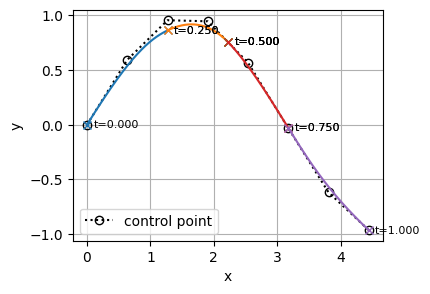

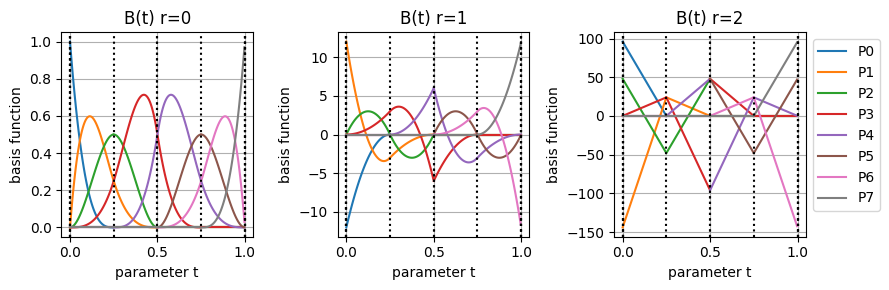

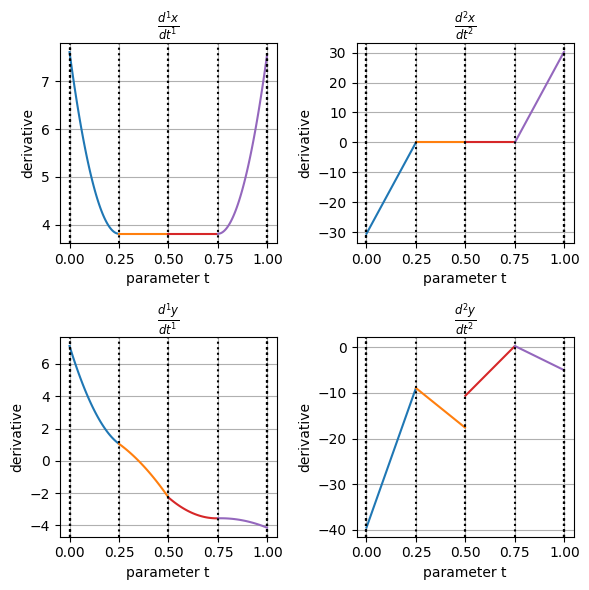

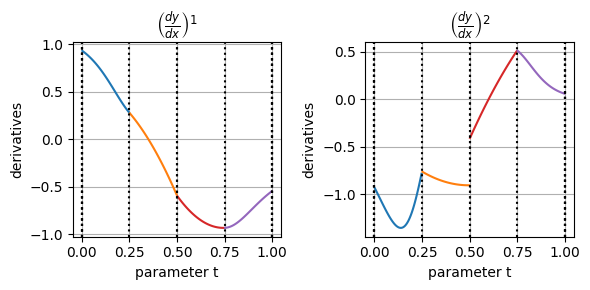

In [23]:
bspline.plot_bspline(ref_points=None)
bspline.plot_basis_function()
bspline.plot_ddt()
bspline.plot_ddx()

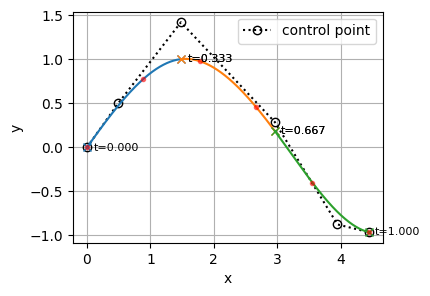

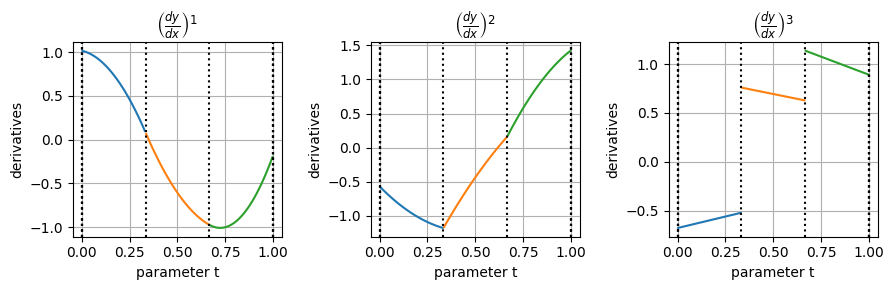

In [24]:
# --- 空のBスプラインオブジェクトを初期化 ---
# この段階ではノットベクトルや制御点は未設定
bspline = MyBSpline()

# --- 補間点の定義 ---
n_cp = 6  # 制御点数（補間点数と一致させることで完全補間を実現）
k = 3            # Bスプラインの次数（3次＝キュービック）

# x座標：0 〜 √2π の範囲を等間隔に分割
x = np.linspace(0, np.sqrt(2) * np.pi, n_cp)

# y座標：xに対応するsin関数の値（滑らかな波形）
y = np.sin(x)

# 補間点を2次元座標としてまとめる（shape: [n_cp, 2]）
interpolate_points = np.column_stack((x, y))

# --- Bスプラインのフィッティング（補間条件付き） ---
# sample_points=None → 補間点のみを使ってフィッティング
# u_interp=None → パラメータ値は自動的に均等割り当て
# n_cp → 制御点数（補間点数と一致）
# degree=k → 指定された次数（例：3次＝キュービック）

control_points = bspline.fit_Bspline(
    sample_points=None,
    interpolate_points=interpolate_points,
    # u_interp=None,
    n_cp=n_cp,
    k=k,
)

# --- ノットベクトルの再計算 ---
# 補間点に対応するノットベクトルを生成（open uniform knot）
knot_vector = bspline._calc_knot_vector(n_cp, k)

# --- フィッティング結果を使って新たにBスプラインオブジェクトを生成 ---
# ノットベクトルと制御点を明示的に指定して初期化
bspline = MyBSpline(knot_vector, control_points, k)

# --- Bスプライン曲線の可視化 ---
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddx()

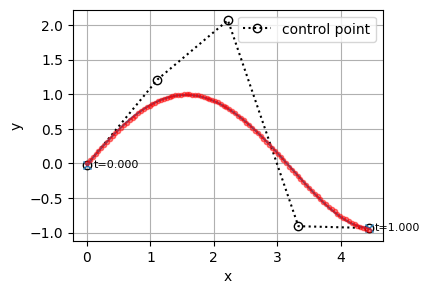

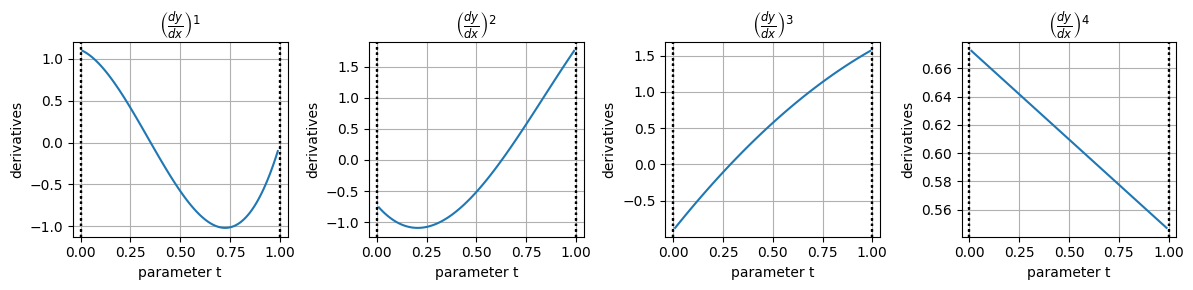

In [25]:
# --- サンプル点の定義 ---
# x座標：0 〜 √2π の範囲を100分割した等間隔の点
x = np.linspace(0, np.sqrt(2) * np.pi, 100)

# y座標：xに対応するsin関数の値（滑らかな波形）
y = np.sin(x)

# サンプル点を2次元座標としてまとめる（shape: [100, 2]）
sample_points = np.column_stack((x, y))

# --- 制御点数の設定 ---
n_cp = 5         # 制御点数（少ないほど近似の自由度が低くなる）
k = 4            # Bスプラインの次数（3次＝キュービック）

# --- Bスプラインオブジェクトの初期化（空の状態） ---
bspline = MyBSpline()

# --- Bスプラインのフィッティング（近似） ---
# sample_points → 近似対象の点群
# interpolate_points=None → 補間条件なし（近似のみ）
# u_interp=None → パラメータ値は自動的に均等割り当て
# n_cp → 制御点数（自由度の調整）
# degree=k → 指定された次数（例：3次＝キュービック）

control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp,
    k=k,
)

# --- ノットベクトルの生成（open uniform knot） ---
# ノットベクトルの長さは m = n_cp + k + 1
knot_vector = bspline._calc_knot_vector(n_cp, k)

# --- フィッティング結果を使って新たにBスプラインオブジェクトを生成 ---
# ノットベクトルと制御点を明示的に指定して初期化
bspline = MyBSpline(knot_vector, control_points, k)

# --- Bスプライン曲線の可視化 ---
bspline.plot_bspline(ref_points=sample_points)
bspline.plot_ddx()


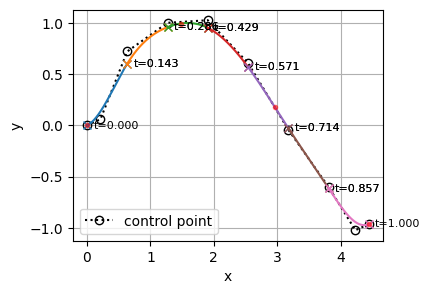

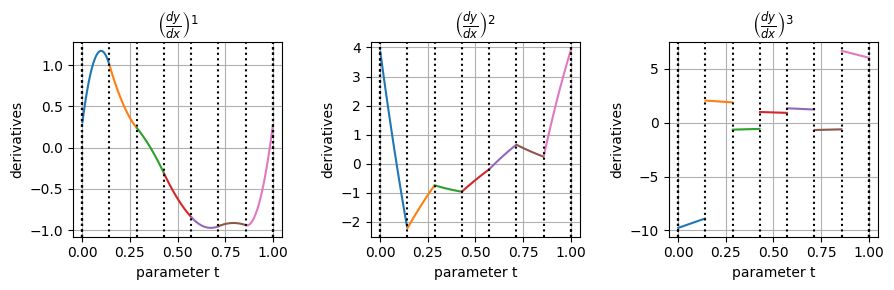

In [26]:
# --- 空のBスプラインオブジェクトを初期化 ---
# この段階ではノットベクトルや制御点は未設定
bspline = MyBSpline()

# --- フィッティングに使用するサンプル点の定義 ---
n_cp = 10  # 制御点数（近似の自由度を決定）
k = 3      # Bスプラインの次数（3次＝キュービック）

# x座標：0 〜 √2π の範囲を100分割した等間隔の点
x = np.linspace(0, np.sqrt(2) * np.pi, 100)

# y座標：xに対応するsin関数の値（滑らかな波形）
y = np.sin(x)

# サンプル点を2次元座標としてまとめる（shape: [100, 2]）
sample_points = np.column_stack((x, y))

# --- 補間点の定義（曲線が厳密に通過すべき点） ---
# 少数の代表点を選び、補間条件として与える
x = np.linspace(0, np.sqrt(2) * np.pi, 4)
y = np.sin(x)
interpolate_points = np.column_stack((x, y))

# --- Bスプラインのフィッティング（補間＋近似＋周期条件） ---
# sample_points → 近似対象の点群
# interpolate_points → 曲線が厳密に通過すべき点
# periodic=True → 曲線の始点と終点で1階・2階微分が一致する周期条件を課す

control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp,
    k=k,
    interpolate_points=interpolate_points,
    periodic=True,
)

# --- ノットベクトルの生成（open uniform knot） ---
# ノットベクトルの長さは m = n_cp + k + 1
# 端点に k 個の重複ノットを配置し、内部は均等分割
knot_vector = bspline._calc_knot_vector(n_cp, k)

# --- フィッティング結果を使って新たにBスプラインオブジェクトを生成 ---
# ノットベクトルと制御点を明示的に指定して初期化
bspline = MyBSpline(knot_vector, control_points, k)

# --- Bスプライン曲線の可視化 ---
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddx()


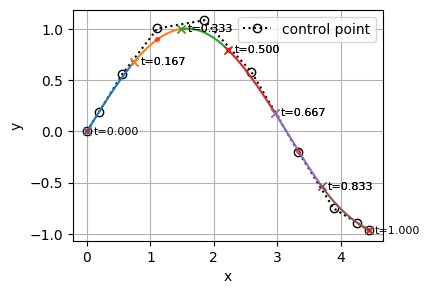

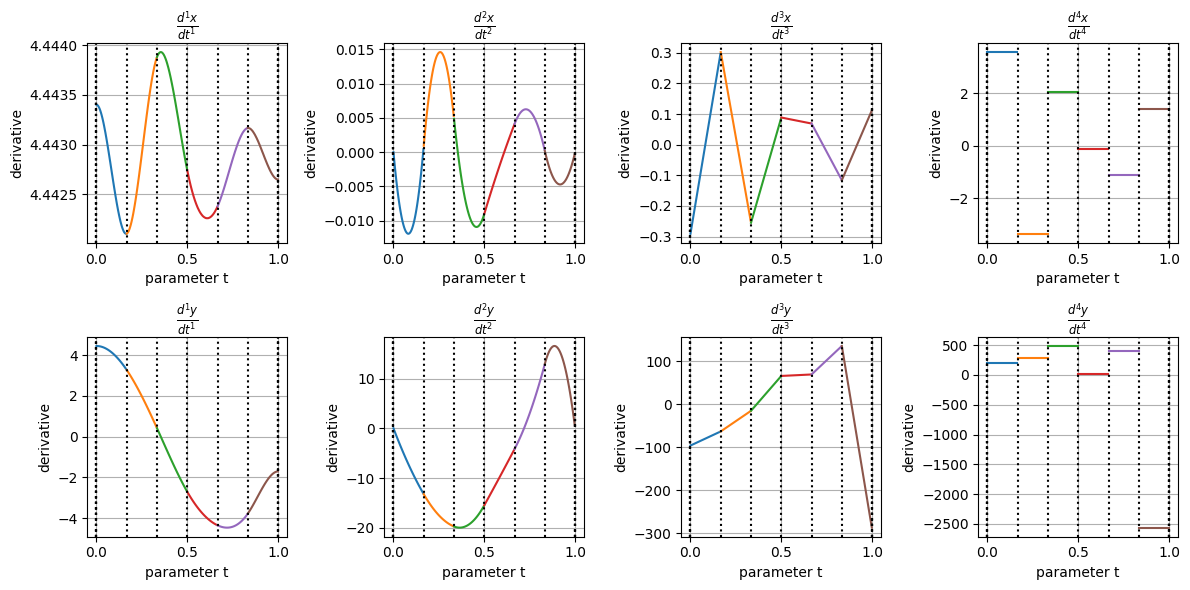

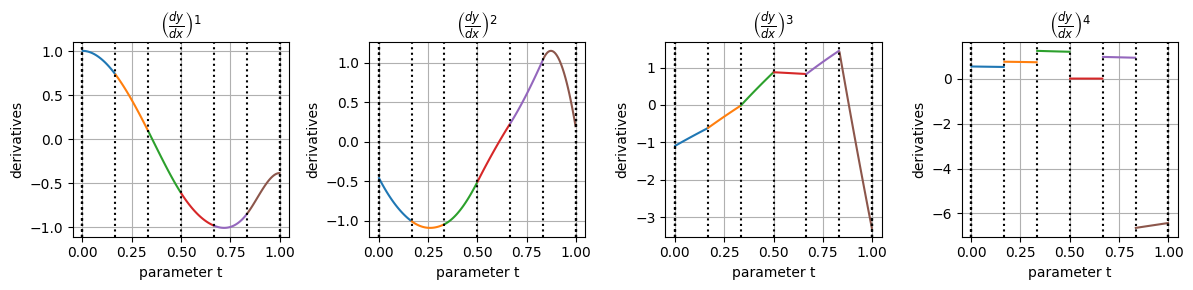

In [27]:
# --- 空のBスプラインオブジェクトを初期化 ---
# この段階ではノットベクトルや制御点は未設定
bspline = MyBSpline()

# --- フィッティングに使用するサンプル点の定義 ---
n_cp = 10  # 制御点数（近似の自由度を決定）
k = 4      # Bスプラインの次数（3次＝キュービック）

# x座標：0 〜 √2π の範囲を100分割した等間隔の点
x = np.linspace(0, np.sqrt(2) * np.pi, 100)

# y座標：xに対応するsin関数の値（滑らかな波形）
y = np.sin(x)

# サンプル点を2次元座標としてまとめる（shape: [100, 2]）
sample_points = np.column_stack((x, y))

# --- 補間点の定義（曲線が厳密に通過すべき点） ---
# 少数の代表点を選び、補間条件として与える
x = np.linspace(0, np.sqrt(2) * np.pi, 5)
y = np.sin(x)
interpolate_points = np.column_stack((x, y))

# --- Bスプラインのフィッティング（補間＋近似＋周期条件） ---
# sample_points → 近似対象の点群
# interpolate_points → 曲線が厳密に通過すべき点
# periodic=True → 曲線の始点と終点で1階・2階微分が一致する周期条件を課す

constraints = [
    # (2, [0.5, np.sin(0.5)]), (3, [0.5, np.sin(0.5)]), 
    (2, [x[0], np.sin(x[0])]), (2, [x[-1], np.sin(x[-1])]),
]

control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp,
    k=k,
    interpolate_points=interpolate_points,
    constraints=constraints,
    # periodic=True,
)

# --- ノットベクトルの生成（open uniform knot） ---
# ノットベクトルの長さは m = n_cp + k + 1
# 端点に k 個の重複ノットを配置し、内部は均等分割
knot_vector = bspline.t

# --- フィッティング結果を使って新たにBスプラインオブジェクトを生成 ---
# ノットベクトルと制御点を明示的に指定して初期化
bspline = MyBSpline(knot_vector, control_points, k)

# --- Bスプライン曲線の可視化 ---
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddt()
bspline.plot_ddx()

## test

In [28]:
# --- Bスプラインの次数と制御点数の設定 ---
k = 3           # Bスプラインの次数（4次＝クインティック）
n_cp = 13       # 制御点数（曲線の自由度）
n_sample = 100

# --- キンク（曲率変化点）の指定 ---
# 曲線の形状を変化させたい位置を指定（例：0.3）
kink_list = []
kink_list = [(0.3, k)]


knot_vector =  [0.000, 0.000, 0.000, 0.000, 0.150, 0.300, 0.300, 0.300, 0.417, 0.533, 0.650, 0.767, 0.883, 1.000, 1.000, 1.000, 1.000]
knot_vector =  [0.000, 0.000, 0.000, 0.000, 0.150, 0.300, 0.300, 0.300, 0.417, 0.533, 0.650, 0.767, 0.883, 1.000, 1.000, 1.000, 1.000]


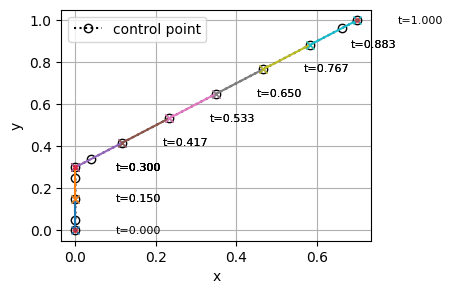

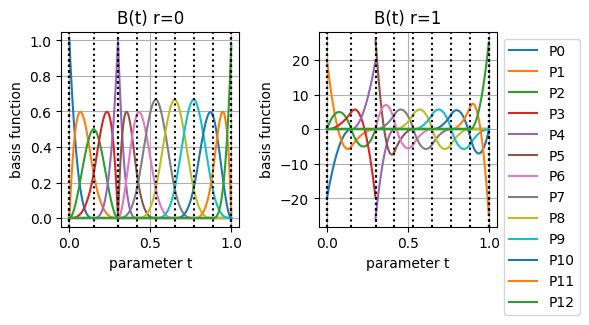

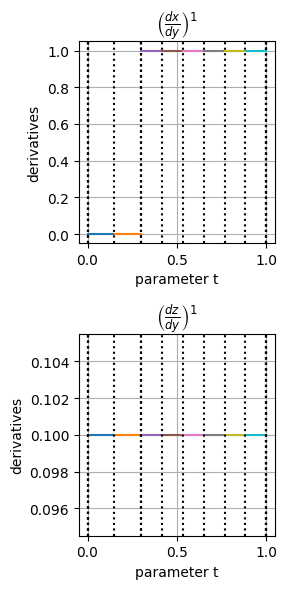

In [29]:
np.set_printoptions(linewidth=999)

# --- Bスプラインオブジェクトの初期化（空の状態） ---
bspline = MyBSpline()

# --- 3次元空間上の形状定義（root → mid → tip） ---
root = np.array([0, 0, 0])         # 始点
mid = np.array([0, 0.3, 0.03])     # 中間点（キンク位置）
tip = np.array([0.7, 1.0, 0.10])   # 終点

# --- サンプル点の生成（root→mid→tipを直線で接続） ---
sample_points = []
# root→mid間を線形補間
for val in np.linspace(0, 1, int(0.3 * n_sample) + 1)[:-1]:
    sample_points.append(root * (1 - val) + mid * val)
# mid→tip間を線形補間
for val in np.linspace(0, 1, int(0.7 * n_sample) + 1)[:-1]:
    sample_points.append(mid * (1 - val) + tip * val)
# tipを追加
sample_points.append(tip)

# --- 補間点の定義（曲線が厳密に通過すべき点） ---
interpolate_points = np.column_stack([root, mid, tip]).T
u_interp = np.array([0, 0.3, 1.0])  # 各補間点に対応するパラメータ値

# --- ノットベクトルの生成（キンク位置を反映） ---
knot_vector = bspline._calc_knot_vector(n_cp, k, kink_list=kink_list)
print('knot_vector = ', '['+', '.join([f'{val:.3f}' for val in knot_vector])+']')

# --- Bスプラインのフィッティング（補間＋近似） ---
control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    interpolate_points=interpolate_points,
    # u_interp=u_interp,
    n_cp=n_cp,
    k=k,
    knot_vector=knot_vector,
)

# --- フィッティング結果を使ってBスプラインオブジェクトを再構築 ---
bspline = MyBSpline(knot_vector, control_points, k)

# --- ノットベクトルの確認出力 ---
print('knot_vector = ', '['+', '.join([f'{val:.3f}' for val in bspline.t])+']')

# --- Bspline曲線の可視化 ---
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_basis_function()
bspline.plot_ddx(axis=1)

knot_vector =  [0.000, 0.000, 0.000, 0.000, 0.150, 0.300, 0.417, 0.533, 0.650, 0.767, 0.883, 1.000, 1.000, 1.000, 1.000]
knot_vector =  [0.000, 0.000, 0.000, 0.000, 0.150, 0.300, 0.300, 0.300, 0.417, 0.533, 0.650, 0.767, 0.883, 1.000, 1.000, 1.000, 1.000]


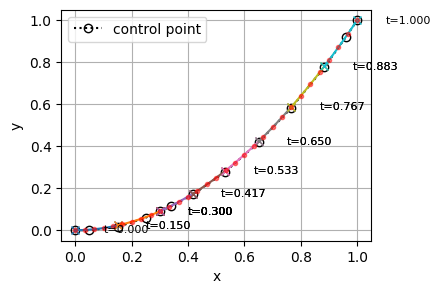

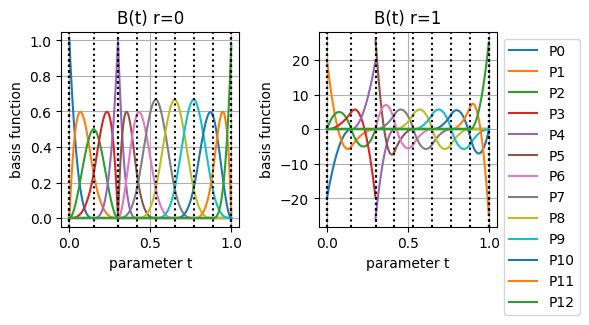

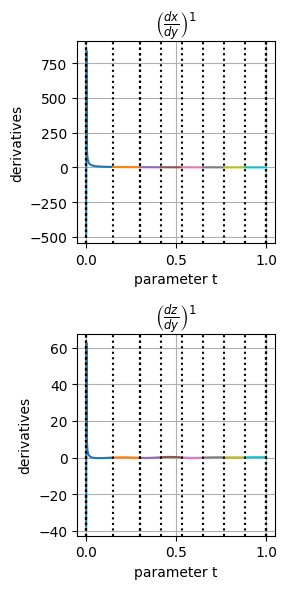

In [30]:
# --- 新しいBスプラインオブジェクトの初期化 ---
bspline = MyBSpline()

# --- サンプル点の定義（y軸に沿って √y の曲線） ---
# y = np.linspace(0, 1, 31)
# x = np.sqrt(y)
x = np.linspace(0, 1, 31)
y = x ** 2
z = 0.1 * (y ** 2)
sample_points = np.column_stack([x, y, z])  # 3次元座標

# --- 補間点の定義（√yの代表点） ---
u_interp = np.array([0, 0.3, 1.0])
interpolate_points = np.column_stack([np.sqrt(u_interp), u_interp, 0.1 * u_interp])

# --- ノットベクトルの生成（キンク位置を反映） ---
knot_vector = bspline._calc_knot_vector(n_cp, k, kink_list=kink_list)

# --- ノットベクトルからキンク（重複）を除去 ---
knot_vector, knot_to_add = bspline._remove_kink_from_knot(knot_vector, k)

# --- 制御点数をノットベクトルから再計算 ---
n_cp = len(knot_vector) - (k + 1)

# --- Bスプラインのフィッティング（補間＋近似） ---
control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    interpolate_points=interpolate_points,
    # u_interp=u_interp,
    n_cp=n_cp,
    k=k,
    knot_vector=knot_vector,
)

# --- ノットベクトルの確認出力 ---
print('knot_vector = ', '['+', '.join([f'{val:.3f}' for val in bspline.t])+']')

# --- フィッティング結果を使ってBスプラインオブジェクトを再構築 ---
bspline = MyBSpline(knot_vector, control_points, k)

# --- 除去されたキンクノットを再挿入（必要に応じて） ---
for knot in knot_to_add:
    counter = Counter(knot_to_add)
    bspline = bspline.insert_knot(knot, 1)

# --- 最終的なノットベクトルの確認出力 ---
print('knot_vector = ', '['+', '.join([f'{val:.3f}' for val in bspline.t])+']')

# --- Bspline曲線の可視化 ---
bspline.plot_bspline(ref_points=sample_points)
bspline.plot_basis_function()
bspline.plot_ddx(axis=1)

## test2

In [ ]:
def fx(x):
    x = np.asarray(x)
    y = np.where(
        x <= 0.5,
        np.sqrt(x),
        np.sqrt(0.5) + (1/2)*(0.5**(-1/2))*(x - 0.5)
    )
    return y


def fy(y):
    y = np.asarray(y)
    y_split = np.sqrt(0.5)
    a = 1 / (2 * np.sqrt(0.5))  # 傾き

    x = np.where(
        y <= y_split,
        y**2,
        0.5 + (y - y_split) / a
    )
    return x


def equal_arc_length_points(fx, a, b, n=100):
    # 解像度（累積長さの評価用のサンプル数）
    num_samples = 1000

    # xのサンプル点
    x_dense = np.linspace(a, b, num_samples)
    y_dense = fx(x_dense)

    # 曲線の勾配（dy/dx）→ dx, dy による距離要素を計算
    dx = np.gradient(x_dense)
    dy = np.gradient(y_dense)

    if y_dense.ndim == 1:
        ds = np.sqrt(dx**2 + dy**2)
    else:
        dy_norm = np.linalg.norm(dy, axis=0)
        ds = np.sqrt(dx**2 + dy_norm**2)

    # 累積距離（アーク長）
    arc_length = cumulative_trapezoid(ds, x_dense, initial=0)

    # アーク長の最大値をn等分する
    target_lengths = np.linspace(0, arc_length[-1], n + 1)

    # アーク長に対するxの補間関数を作成
    interp_func = interp1d(arc_length, x_dense)

    # 等アーク長に対応するx座標を取得
    x_equal = interp_func(target_lengths)

    return x_equal


sample_points.shape =  (1000, 2)
interpolate_points.shape =  (5, 2)


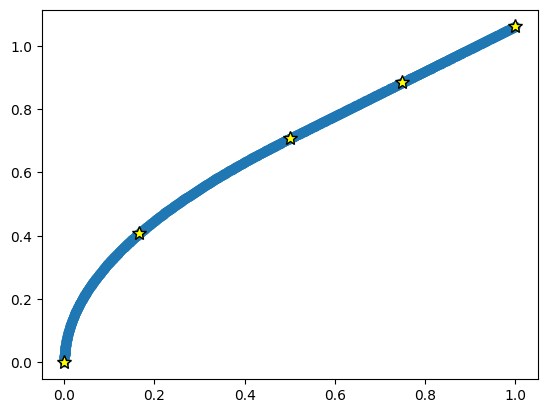

In [32]:
n_sample = 999
x = equal_arc_length_points(fx, a=0.0, b=1.0, n=n_sample)
y = fx(x)
sample_points = np.column_stack((x, y))
print('sample_points.shape = ', sample_points.shape)

n_cp = 10

# --- 補間点の定義（曲線が厳密に通過すべき点） ---
n = 2
x = np.concatenate([equal_arc_length_points(fx, a=0.0, b=0.5, n=n), equal_arc_length_points(fx, a=0.5, b=1.0, n=n)[1:]])
y = fx(x)
interpolate_points = np.column_stack((x, y))
print('interpolate_points.shape = ', interpolate_points.shape)

fig, ax = plt.subplots()
ax.plot(sample_points[:, 0], sample_points[:, 1], 'o-', markerfacecolor='none')
ax.plot(interpolate_points[:, 0], interpolate_points[:, 1], '*', color='k', markerfacecolor='yellow', markersize=10)
plt.show()

u_kink 0.5942053117948483
len(knot_vector) 14
knot_vector = [0.0, 0.0, 0.0, 0.0, 0.148551, 0.297103, 0.445654, 0.5942053117948483, 0.72947, 0.864735, 1.0, 1.0, 1.0, 1.0]


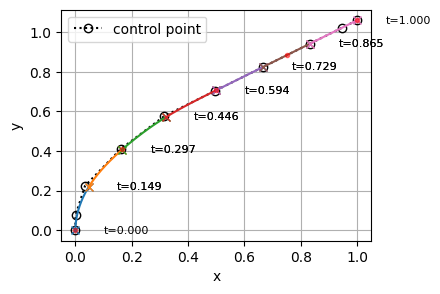

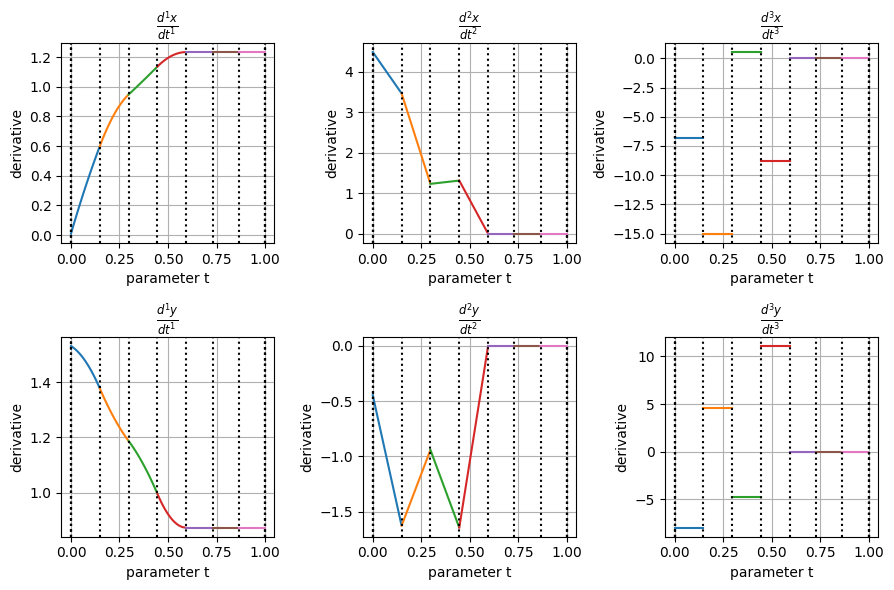

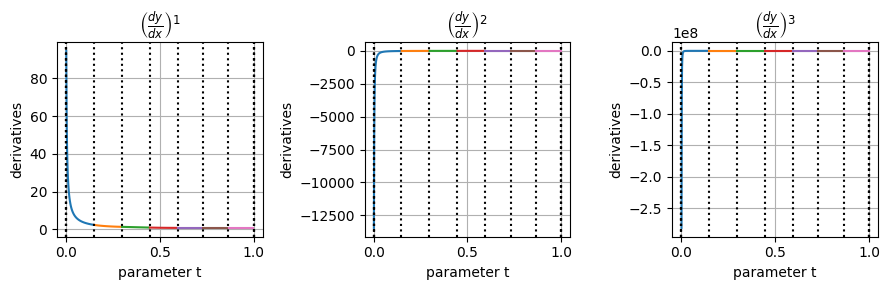

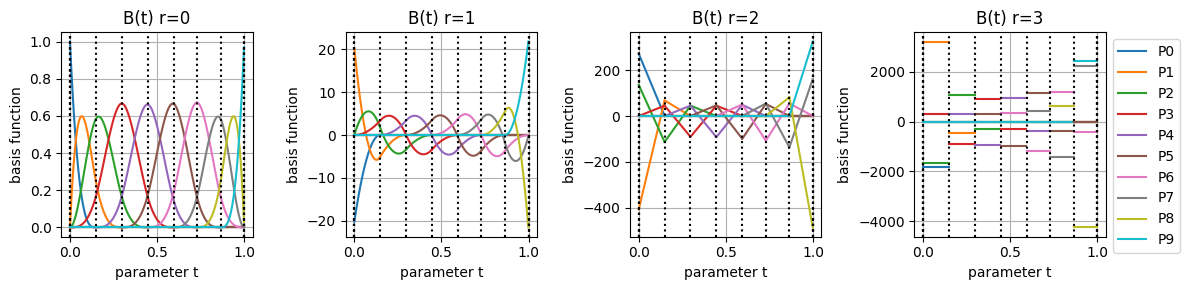

In [33]:
bspline = MyBSpline()
k = 3      # Bスプラインの次数（3次＝キュービック）
constraints = [
    (2, [0.5, fx(0.5)]), (3, [0.5, fx(0.5)]), 
    (2, [1.0, fx(1.0)]), 
    # (3, [1.0, fx(1.0)]),
]
kink_points = [[0.5, fx(0.5)]]
u_kink = bspline._get_u_interp(sample_points, np.linspace(0, 1, len(sample_points)+1), kink_points)[0]
kink_list = [(u_kink, 1)]  # 位置と重複度
knot_vector = bspline._calc_knot_vector(n_cp=n_cp, k=k, kink_list=kink_list)
print('u_kink', u_kink)
print('len(knot_vector)', len(knot_vector))
print('knot_vector = ['+', '.join([str(val) for val in knot_vector])+']')
control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp,
    k=k,
    interpolate_points=interpolate_points,
    knot_vector=knot_vector,
    constraints=constraints,
)
bspline = MyBSpline(knot_vector, control_points, k)
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddt()
bspline.plot_ddx()
bspline.plot_basis_function()

# sample3 = np.column_stack([np.linspace(0, 1, n), bspline(np.linspace(0, 1, n)).flatten()])
sample3 = bspline(np.linspace(0, 1, n_sample+1))

u_kink 0.5942053117948483
len(knot_vector) 17
knot_vector = [0.0, 0.0, 0.0, 0.0, 0.0, 0.148551, 0.297103, 0.445654, 0.5942053117948483, 0.5942053117948483, 0.72947, 0.864735, 1.0, 1.0, 1.0, 1.0, 1.0]


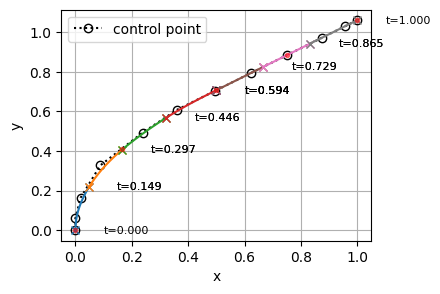

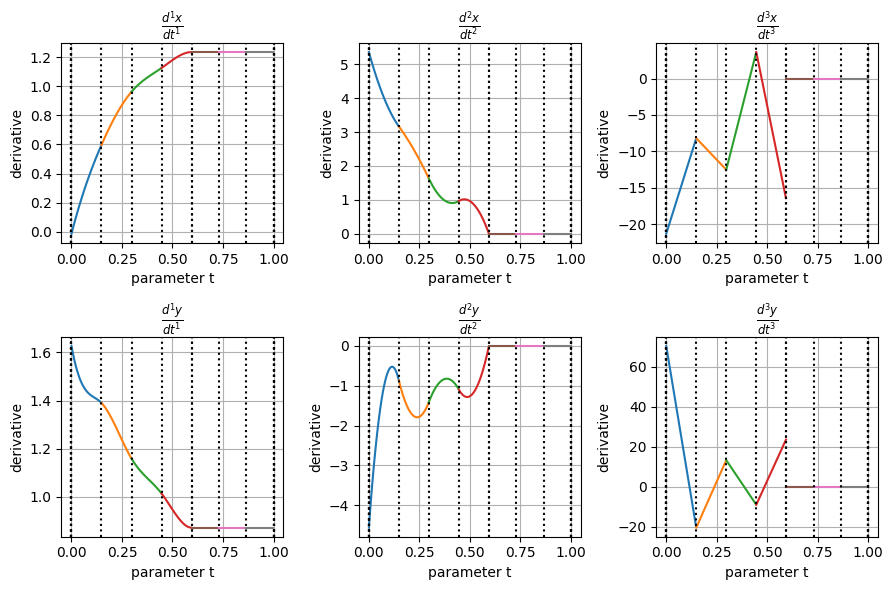

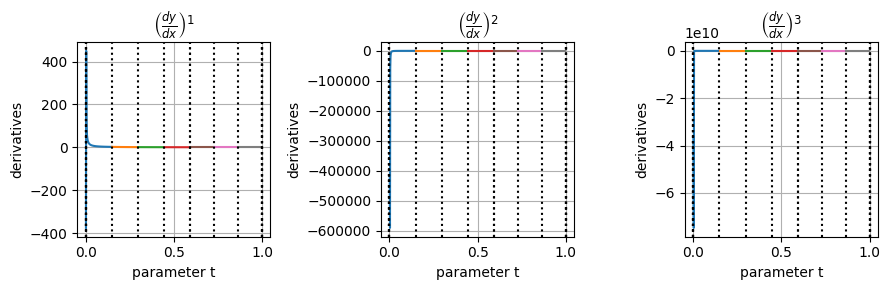

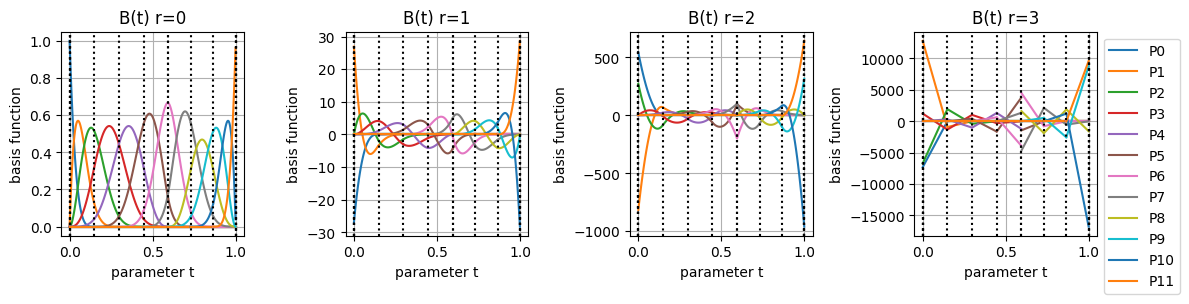

In [34]:
bspline = MyBSpline()
k = 4      # Bスプラインの次数（3次＝キュービック）
constraints = [
    (2, [0.5, fx(0.5)]), (3, [0.5, fx(0.5)]), 
    (2, [1.0, fx(1.0)]), (3, [1.0, fx(1.0)]),
]
kink_points = [[0.5, fx(0.5)]]
u_kink = bspline._get_u_interp(sample_points, np.linspace(0, 1, len(sample_points)+1), kink_points)[0]
kink_list = [(u_kink, 2)]  # 位置と重複度
knot_vector = bspline._calc_knot_vector(n_cp=n_cp+2, k=k, kink_list=kink_list)
print('u_kink', u_kink)
print('len(knot_vector)', len(knot_vector))
print('knot_vector = ['+', '.join([str(val) for val in knot_vector])+']')
control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp+2,
    k=k,
    interpolate_points=interpolate_points,
    knot_vector=knot_vector,
    constraints=constraints,
)
bspline = MyBSpline(knot_vector, control_points, k)
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddt()
bspline.plot_ddx()
bspline.plot_basis_function()

# sample4 = np.column_stack([np.linspace(0, 1, n), bspline(np.linspace(0, 1, n)).flatten()])
sample4 = bspline(np.linspace(0, 1, n_sample+1))

u_kink 0.5942053117948483
len(knot_vector) 20
knot_vector = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.118841, 0.237682, 0.356523, 0.475364, 0.5942053117948483, 0.5942053117948483, 0.72947, 0.864735, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


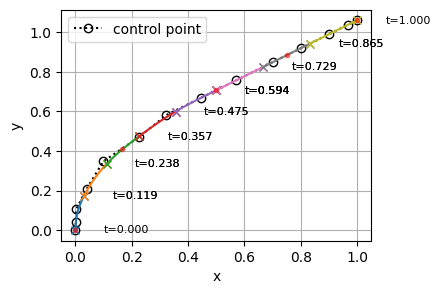

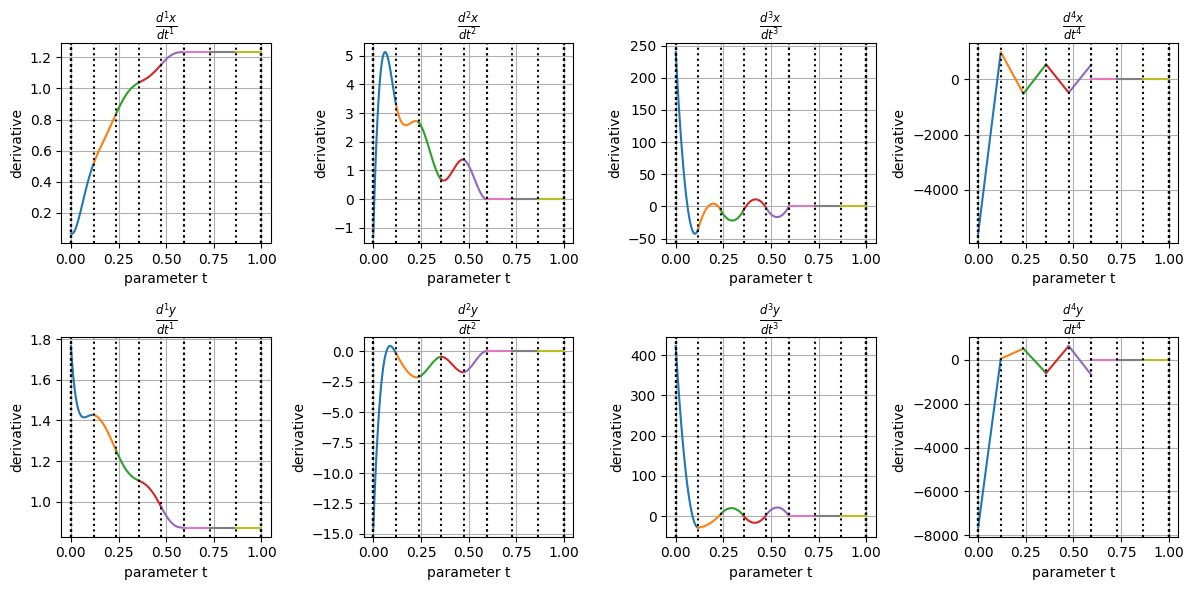

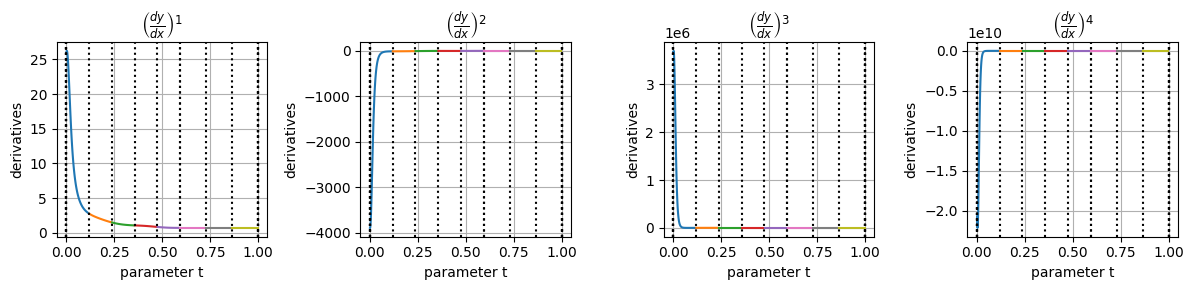

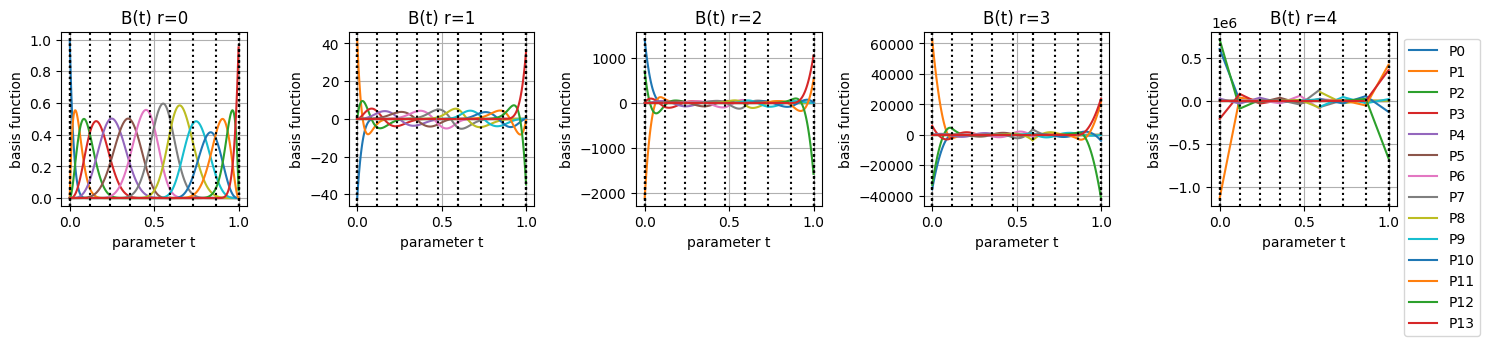

In [35]:
bspline = MyBSpline()
k = 5      # Bスプラインの次数（3次＝キュービック）
constraints = [
    (2, [0.5, fx(0.5)]), (3, [0.5, fx(0.5)]), (4, [0.5, fx(0.5)]),
    (2, [1.0, fx(1.0)]), (3, [1.0, fx(1.0)]), (4, [1.0, fx(1.0)]),
]
kink_points = [[0.5, fx(0.5)]]
u_kink = bspline._get_u_interp(sample_points, np.linspace(0, 1, len(sample_points)+1), kink_points)[0]
kink_list = [(u_kink, 2)]  # 位置と重複度
knot_vector = bspline._calc_knot_vector(n_cp=n_cp+4, k=k, kink_list=kink_list)
print('u_kink', u_kink)
print('len(knot_vector)', len(knot_vector))
print('knot_vector = ['+', '.join([str(val) for val in knot_vector])+']')
control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp+4,
    k=k,
    interpolate_points=interpolate_points,
    knot_vector=knot_vector,
    constraints=constraints,
)
bspline = MyBSpline(knot_vector, control_points, k)
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddt()
bspline.plot_ddx()
bspline.plot_basis_function()

# sample5 = np.column_stack([np.linspace(0, 1, n), bspline(np.linspace(0, 1, n)).flatten()])
sample5 = bspline(np.linspace(0, 1, n_sample+1))

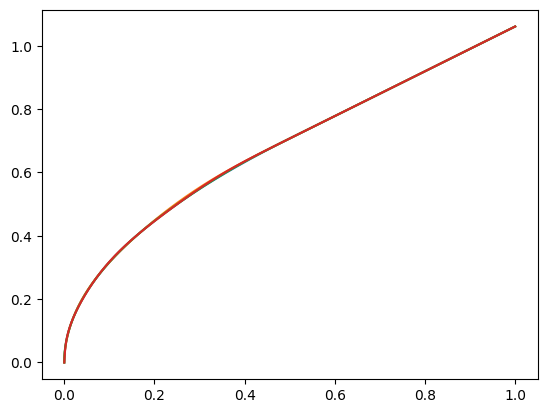

In [36]:
fig, ax = plt.subplots()
ax.plot(sample_points[:, 0], sample_points[:, 1], '-', markerfacecolor='none', label='sample')
ax.plot(sample3[:, 0], sample3[:, 1], '-', markerfacecolor='none', label='k=3')
ax.plot(sample4[:, 0], sample4[:, 1], '-', markerfacecolor='none', label='k=4')
ax.plot(sample5[:, 0], sample5[:, 1], '-', markerfacecolor='none', label='k=5')
plt.show()

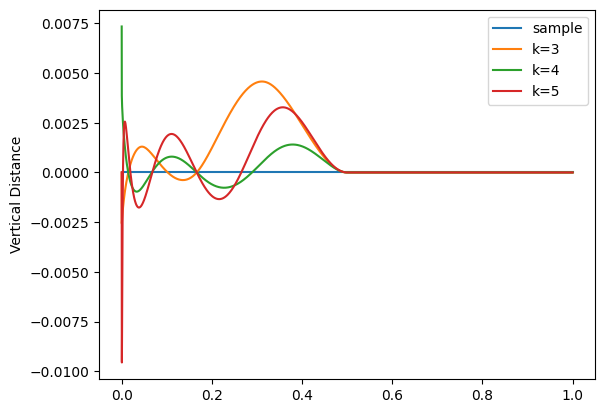

In [37]:
fig, ax = plt.subplots()

# 基準ライン（ゼロ誤差ライン）
ax.plot(sample_points[:, 0], np.zeros_like(sample_points[:, 0]), '-', label='sample')

# 各補間結果との距離を計算して描画
for sample, label in zip([sample3, sample4, sample5], ['k=3', 'k=4', 'k=5']):
    interp_y = np.interp(sample_points[:, 0], sample[:, 0], sample[:, 1])
    # 距離 = 垂直方向の差（1次元の場合）
    distances = interp_y - sample_points[:, 1]
    ax.plot(sample_points[:, 0], distances, '-', markerfacecolor='none', label=label)

ax.set_ylabel('Vertical Distance')  # 距離ラベルに変更
ax.legend()
plt.show()


### interpolate

In [38]:
# --- 補間点の定義（曲線が厳密に通過すべき点） ---
n = 2
x = np.concatenate([equal_arc_length_points(fx, a=0.0, b=0.5, n=n), equal_arc_length_points(fx, a=0.5, b=1.0, n=n)[1:]])
y = fx(x)
interpolate_points = np.column_stack((x, y))
print('interpolate_points.shape = ', interpolate_points.shape)


interpolate_points.shape =  (5, 2)


knot_vector = [0.0, 0.0, 0.0, 0.0, 0.25, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0]


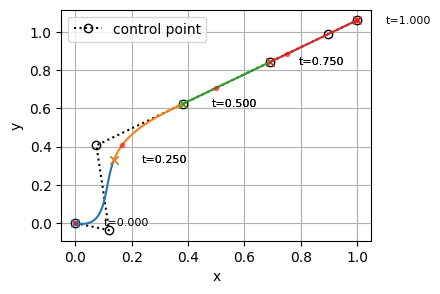

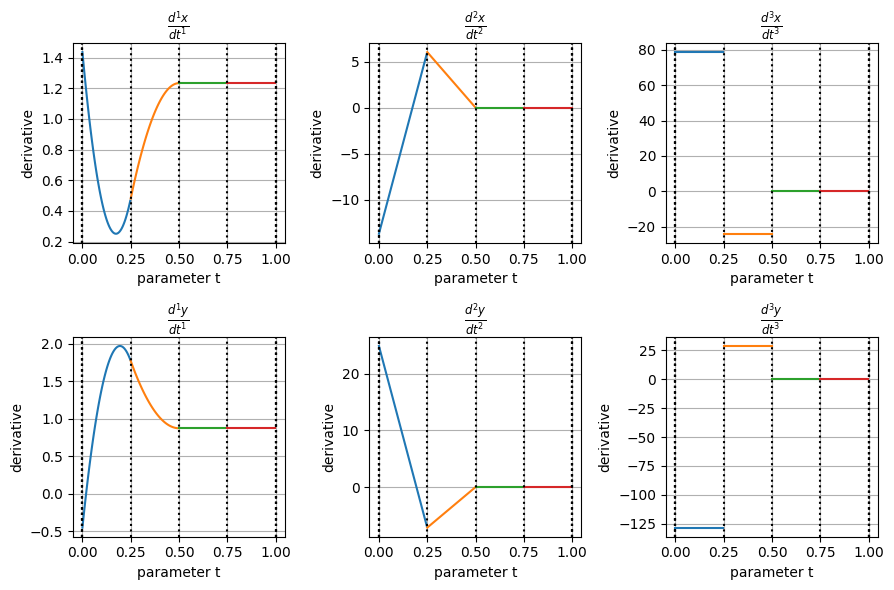

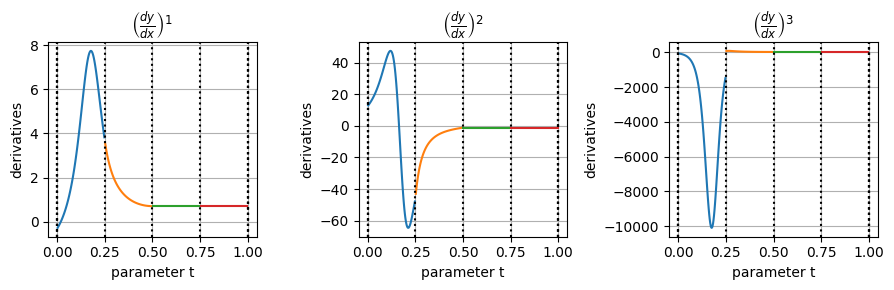

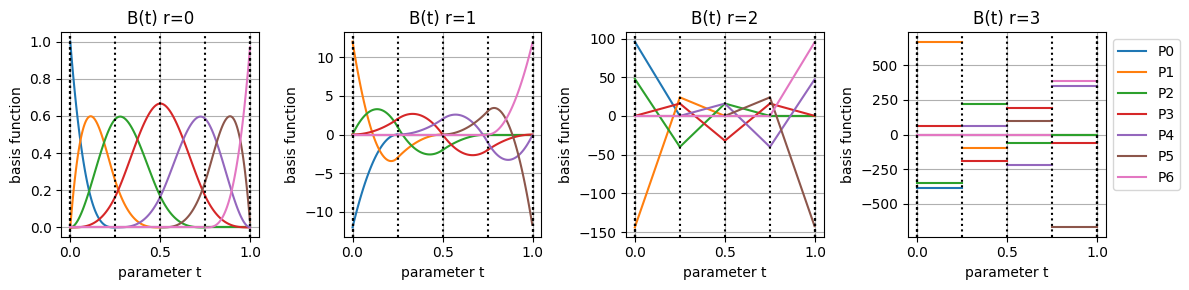

In [39]:
bspline = MyBSpline()
k = 3      # Bスプラインの次数（3次＝キュービック）
constraints = [
    (2, [0.5, fx(0.5)]), (3, [0.5, fx(0.5)]), 
    # (2, [1.0, fx(1.0)]),
    # (3, [1.0, fx(1.0)]),
]
n_cp = len(interpolate_points) + len(constraints)
control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp,
    k=k,
    interpolate_points=interpolate_points,
    constraints=constraints,
    # periodic=True,
)
knot_vector = bspline.t
print('knot_vector = ['+', '.join([str(val) for val in bspline.t])+']')
bspline = MyBSpline(knot_vector, control_points, k)

bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddt()
bspline.plot_ddx()
bspline.plot_basis_function()

u_kink 0.5
len(knot_vector) 12
knot_vector = [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]


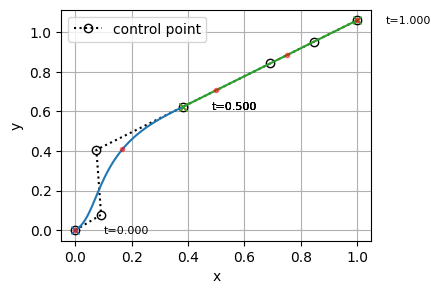

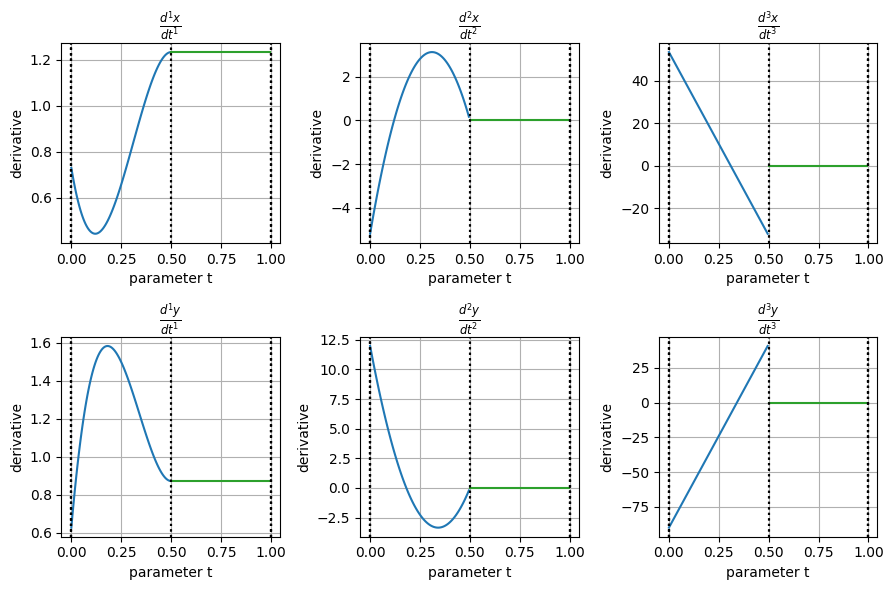

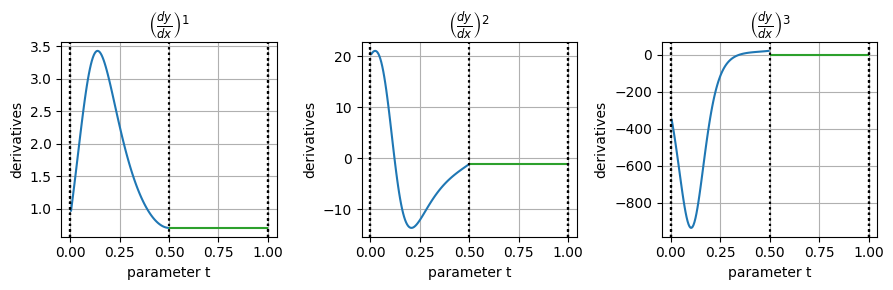

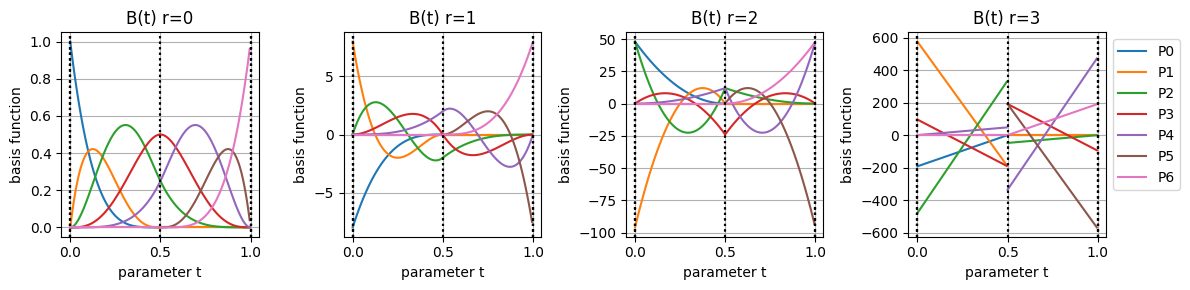

In [40]:
bspline = MyBSpline()
k = 4      # Bスプラインの次数（3次＝キュービック）
constraints = [
    (2, [0.5, fx(0.5)]), (3, [0.5, fx(0.5)]), 
]
kink_points = [[0.5, fx(0.5)]]
n_cp = len(interpolate_points) + len(constraints)
u_kink = bspline._get_u_interp(interpolate_points, np.linspace(0, 1, len(interpolate_points)), kink_points)[0]
kink_list = [(u_kink, 2)]  # 位置と重複度
# u_kink = bspline._get_u_interp(sample_points, np.linspace(0, 1, len(sample_points)+1), kink_points)[0]
# kink_list = [(u_kink, 2)]  # 位置と重複度
knot_vector = bspline._calc_knot_vector(n_cp=n_cp, k=k, kink_list=kink_list)
print('u_kink', u_kink)
print('len(knot_vector)', len(knot_vector))
print('knot_vector = ['+', '.join([str(val) for val in knot_vector])+']')
control_points = bspline.fit_Bspline(
    sample_points=sample_points,
    n_cp=n_cp,
    k=k,
    interpolate_points=interpolate_points,
    knot_vector=knot_vector,
    constraints=constraints,
)
bspline = MyBSpline(knot_vector, control_points, k)
bspline.plot_bspline(ref_points=interpolate_points)
bspline.plot_ddt()
bspline.plot_ddx()
bspline.plot_basis_function()